# Discrete Time Crystal（離散時間結晶）をQulacsでシミュレーションする

結晶とは、空間的な対称性が自発的にやぶれて構造を持つ現象である。時間軸方向でこのような現象がおきるのが時間結晶である。残念ながら連続的な時間並進対称性を破るような時間結晶は存在しないことが証明されているので、外部から周期的に駆動された離散的な並進対称性の破れである、離散時間結晶の破れについて考える。

## イジングハミルトニアンでの時間

イジングハミルトニアン（横磁場なし）は可換なので量子回路で簡単に実装することができる。

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs import Observable
import math

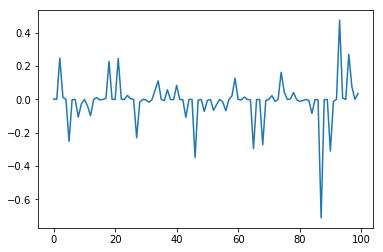

In [59]:
#スピン1/2の数
num_spin=10

#周期
T=1
#シミュレーションする周期数
num_peri =100

#ランダム磁場
hz=[random.random() for i in range(num_spin)]
#hz=[0 for i in range(num_spin)]

IsingDynamics = QuantumCircuit(num_spin)


#一周期分のダイナミクスを定義する
#イジング項の追加
for i in range(num_spin):
    for j in range(i):
        IsingDynamics.add_gate(CNOT(j,i))
        IsingDynamics.add_gate(RZ(i,T))
        IsingDynamics.add_gate(CNOT(j,i))

#ランダム磁場の追加
for i in range(num_spin):
        IsingDynamics.add_gate(RZ(i,T*hz[i]))

#オブザーバブルを定義
X_magnetization = Observable(num_spin)
for i in range(num_spin):
    X_magnetization.add_operator(1.0/num_spin,"X {0}".format(i)) 
    
#各ステップごとにオブザーバーブルを出力してみる
result = []

state = QuantumState(num_spin)
state.set_zero_state()

transversal_H = QuantumCircuit(num_spin)
for i in range(num_spin):
    transversal_H.add_H_gate(i)
    
transversal_H.update_quantum_state(state)

for i in range(num_peri):
    IsingDynamics.update_quantum_state(state)
    result.append(X_magnetization.get_expectation_value(state))
    
plt.plot(result)
plt.show()

離散時間結晶のダイナミクス

In [60]:
#オブザーバブルを定義
Z_magnetization = Observable(num_spin)
for i in range(num_spin):
    Z_magnetization.add_operator(1.0/num_spin,"Z {0}".format(i)) 
    

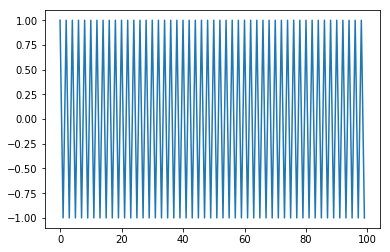

In [69]:
#各ステップごとにオブザーバーブルを出力してみる
result = []


#スピン反転演算子を定義する。
transversal_X =  QuantumCircuit(num_spin)

for i in range(num_spin):
    transversal_X.add_X_gate(i)

    
#初期状態は対称性をやぶった状態にする
state = QuantumState(num_spin)
state.set_zero_state()


# num_peri回繰り返す

for i in range(num_peri):
    result.append(Z_magnetization.get_expectation_value(state))
    IsingDynamics.update_quantum_state(state)
    transversal_X.update_quantum_state(state)
    
plt.plot(result)
plt.show()

当然、2T周期の周期的なダイナミクスが見える。離散時間結晶では、この2T周期性が、スピン反転演算子の摂動に対してロバスト（MBL由来）であることを要求する。


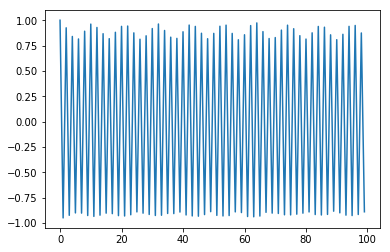

In [70]:
#スピン反転演算子に摂動を加える
transversal_X_rot =  QuantumCircuit(num_spin)


epsilon = 0.1*(np.pi)

for i in range(num_spin):
    transversal_X_rot.add_gate(RX(i,np.pi+epsilon))

result = []
#初期状態は対称性をやぶった状態にする
state = QuantumState(num_spin)
state.set_zero_state()

# num_peri回繰り返す
for i in range(num_peri):
    result.append(Z_magnetization.get_expectation_value(state))
    IsingDynamics.update_quantum_state(state)
    transversal_X_rot.update_quantum_state(state)
    
plt.plot(result)
plt.show()

多少揺らぐものの、周期性が残る。

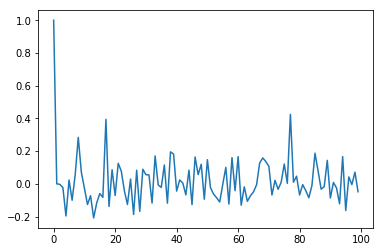

In [71]:
#スピン反転演算子に摂動を加える
transversal_X_rot =  QuantumCircuit(num_spin)


epsilon = 0.5*(np.pi)

for i in range(num_spin):
    transversal_X_rot.add_gate(RX(i,np.pi+epsilon))

    #初期状態は対称性をやぶった状態にする
state = QuantumState(num_spin)
state.set_zero_state()


result = []
# num_peri回繰り返す
for i in range(num_peri):
    result.append(Z_magnetization.get_expectation_value(state))
    IsingDynamics.update_quantum_state(state)
    transversal_X_rot.update_quantum_state(state)
    
plt.plot(result)
plt.show()

ほぼ周期性を失う。

離散結晶ダイナミクスの関数を定義し、出力をフーリヘ変換してみて周期性を定量的にみてみる。

In [65]:
from scipy.fftpack import fft

N = num_peri # data number
dt = 1 # data step [s]

In [72]:
#スピン反転演算子に摂動を加える
def DTC(T,num_peri,epsilon,num_spin):
    #ランダム磁場
    hz=[random.random() for i in range(num_spin)]
    #hz=[0 for i in range(num_spin)]

    IsingDynamics = QuantumCircuit(num_spin)


    #一周期分のダイナミクスを定義する
    #イジング項の追加
    for i in range(num_spin):
        for j in range(i):
            IsingDynamics.add_gate(CNOT(j,i))
            IsingDynamics.add_gate(RZ(i,T))
            IsingDynamics.add_gate(CNOT(j,i))

    #ランダム磁場の追加
    for i in range(num_spin):
            IsingDynamics.add_gate(RZ(i,T*hz[i]))


    #摂動のあるスピンフリップ
    transversal_X_rot =  QuantumCircuit(num_spin)
    for i in range(num_spin):
        transversal_X_rot.add_gate(RX(i,np.pi+epsilon))

    result = []
    #初期状態は対称性をやぶった状態にする
    state = QuantumState(num_spin)
    state.set_zero_state()


    # num_peri回繰り返す
    for i in range(num_peri):
        result.append(Z_magnetization.get_expectation_value(state))
        IsingDynamics.update_quantum_state(state)
        transversal_X_rot.update_quantum_state(state)
    
    return result

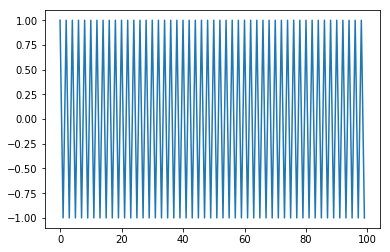

In [87]:
plt.plot(DTC(1.0,100,0.0*np.pi,10))
plt.show()

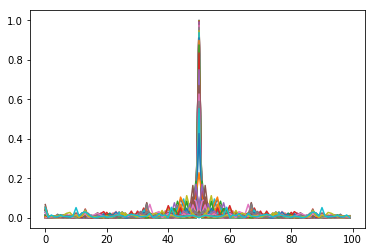

In [100]:
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt

peak = [[],[]]
for i in range(50):
    tmp_result = np.abs(fft(DTC(1.0,100,0.01*i*np.pi,10))/num_peri)
    peak[0].append(0.01*i*np.pi)
    peak[1].append(tmp_result[50])
    plt.plot(tmp_result)
    
plt.show()


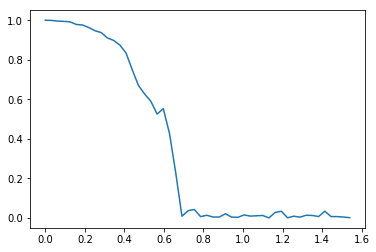

In [101]:
plt.plot(peak[0],peak[1])
plt.show()

ε（スピン反転にたいしる摂動項）が0.7付近で転移がおきている。